In [1]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 469.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 MB 680.3 kB/s eta 0:00:0000:0100:09
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 523.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 596.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 767.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 774.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 755.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 745.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 714.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.7/414.7 kB 871.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import glob

# Paths to dataset
tumor_path = 'Brain MRI Images/brain_tumor_dataset/yes'
no_tumor_path = 'Brain MRI Images/brain_tumor_dataset/no'

# Load and preprocess images and masks
def load_data(image_dir, label_value=1, size=(128, 128)):
    images, masks = [], []
    for img_path in glob.glob(os.path.join(image_dir, '*.jpg')):  # Adjust file type if needed
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale MRI
        img = cv2.resize(img, size) / 255.0  # Normalize to [0, 1]
        mask = np.zeros(size) if label_value == 0 else cv2.imread(img_path.replace('images', 'masks'), cv2.IMREAD_GRAYSCALE)  # Assuming masks exist
        mask = cv2.resize(mask, size) / 255.0  # Normalize to [0, 1]
        images.append(img)
        masks.append(mask)
    return np.array(images).reshape(-1, size[0], size[1], 1), np.array(masks).reshape(-1, size[0], size[1], 1)

tumor_images, tumor_masks = load_data(tumor_path, label_value=1)
no_tumor_images, no_tumor_masks = load_data(no_tumor_path, label_value=0)

# Combine and split data
images = np.concatenate([tumor_images, no_tumor_images], axis=0)
masks = np.concatenate([tumor_masks, no_tumor_masks], axis=0)
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# U-Net Model Definition
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    # Downsampling
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Upsampling
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Compile and Train
model = unet_model()
model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_val, y_val))

# Save Model
model.save('brain_tumor_unet.h5')

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4021 - loss: 0.6785 - val_accuracy: 0.5524 - val_loss: 0.5727
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5610 - loss: 0.6113 - val_accuracy: 0.5524 - val_loss: 0.5416
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5684 - loss: 0.4882 - val_accuracy: 0.5524 - val_loss: 0.3769
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5688 - loss: 0.3417 - val_accuracy: 0.5524 - val_loss: 0.3404
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5231 - loss: 0.3397 - val_accuracy: 0.5524 - val_loss: 0.3378
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6140 - loss: 0.3031 - val_accuracy: 0.5524 - val_loss: 0.3461
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5903 - loss: 0.3209 - val_accuracy: 0.5524 - val_loss: 0.3297
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5765 - loss: 0.2999 - val_accuracy: 0.5524 - val_loss: 0.3266
Epoch 9/

In [7]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('brain_tumor_unet.h5')

In [24]:
import cv2
import numpy as np

def preprocess_image(image_path, size=(128, 128)):
    # Load the MRI image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image
    img = cv2.resize(img, size)
    # Normalize the pixel values
    img = img / 255.0
    # Expand dimensions to match input shape (128, 128, 1)
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

image_path = 'Brain MRI Images/yes/Y15.jpg'
processed_image = preprocess_image(image_path)

In [25]:
# Predict the mask for the input image
predicted_mask = model.predict(processed_image)

# Post-process the mask
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold to binary

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


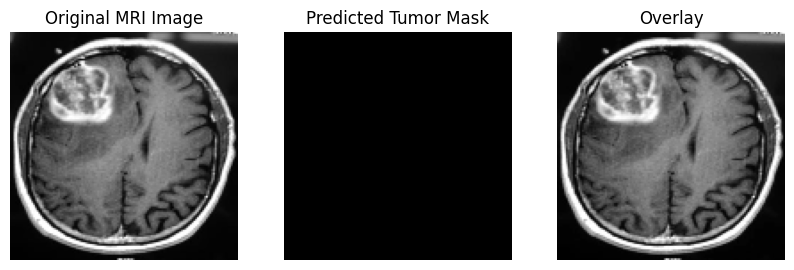

In [26]:
import matplotlib.pyplot as plt

# Load the original image for visualization
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (128, 128))

# Overlay the mask on the image
overlay = np.squeeze(predicted_mask) * 255  # Convert mask to grayscale for visualization
overlay_image = cv2.addWeighted(original_image, 0.7, overlay.astype(np.uint8), 0.3, 0)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original MRI Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Tumor Mask")
plt.imshow(np.squeeze(predicted_mask), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay_image, cmap='gray')
plt.axis('off')

plt.show()

In [12]:
print(processed_image.shape)  # Should output (1, 128, 128, 1)

(1, 128, 128, 1)


In [13]:
print(model.summary())  # Should display the model architecture

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    131,200 │ conv2d_9[0][0]  

 Total params: 7,696,195 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [14]:
print(predicted_mask.shape)  # Should output (1, 128, 128, 1)

(1, 128, 128, 1)


In [15]:
# Create a random test input to verify model functionality
test_input = np.random.random((1, 128, 128, 1))
test_output = model.predict(test_input)
print(test_output.shape)  # Should output (1, 128, 128, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(1, 128, 128, 1)


In [16]:
model.save('brain_tumor_unet.h5')

In [17]:
def preprocess_image(image_path, size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, size)  # Resize to match model input
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [18]:
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

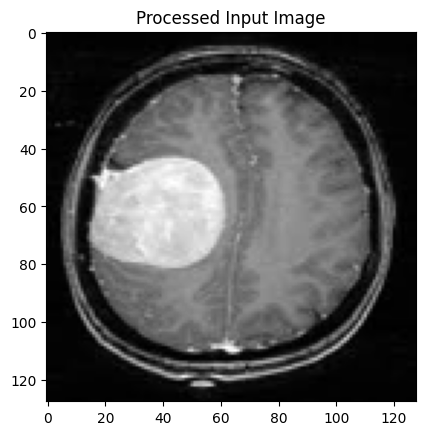

In [19]:
plt.imshow(processed_image[0, :, :, 0], cmap='gray')
plt.title("Processed Input Image")
plt.show()

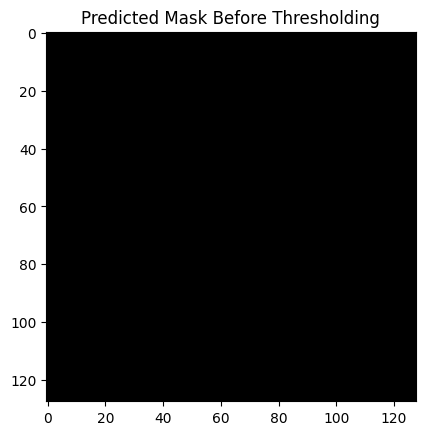

In [20]:
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.title("Predicted Mask Before Thresholding")
plt.show()